# Resonant cavity - Discussion

In [2]:
"""
# Temporary 'hack' for working directory not coinciding with file directory
import os
os.chdir('/home/fenics/shared/examples/1_resonant_cavity')

# Needed for plotting
import pickle
root = os.path.abspath(os.path.join('__file__' ,'../../..'))

%load_ext autoreload
%autoreload 2
"""

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
cm = matplotlib.cm.get_cmap('inferno')
np.random.seed(1)

import fenics as fen
import mshr
from two_dimensional_cavity import TwoDimensionalCavity
from rectangular_cavity import RectangularCavity

from context import src
from src.vector_space import VectorSpaceL2
from src.minimal_rational_interpolation import MinimalRationalInterpolation
import src.helpers as helpers

## Rectangular cavity

In [4]:
Lx, Ly = 5.0, 1.0
Nx, Ny = 101, 21
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
RC = RectangularCavity(Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, g_N=g_N)
RC.setup()

class inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<Ly

### Visualize solutions

#### First resonant solution

/home/fenics/shared/examples/resonant_cavity/rectangular_cavity.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  u_func.vector()[:] = u_vec


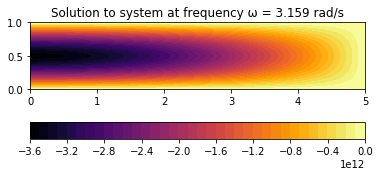

In [5]:
a = 3
b = 5

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

omega = eigfreqs[0]
RC.solve(omega)
RC.plot_solution(cmap=cm)

In [ ]:
#solution = RC.get_solution()
#coords = RC.V.tabulate_dof_coordinates().reshape((-1, 2))
#with open(root + '/report/plots/rectangular_cavity_mode1.pkl', 'wb') as f:
#    pickle.dump([solution, coords, omega], f)

#### Sixth resonant solution

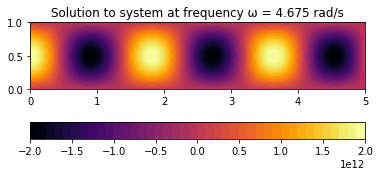

In [8]:
eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

omega = eigfreqs[5]
RC.solve(omega)
RC.plot_solution(cmap=cm)

In [ ]:
#solution = RC.get_solution()
#coords = RC.V.tabulate_dof_coordinates().reshape((-1, 2))
#with open(root + '/report/plots/rectangular_cavity_mode5.pkl', 'wb') as f:
#    pickle.dump([solution, coords, omega], f)

### Analyze frequency response

/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


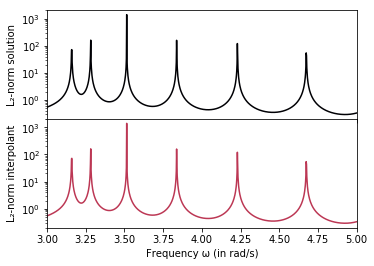

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(5.55, 4), sharex=True)

omegas = np.linspace(a, b, 1000)
RC.solve(omegas, solver='fenics')
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
FE_norms = helpers.plot_solution_norms(ax[0], solution, VS, color=cm(0.0))

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-2)

ax[1].set_ylabel('L\u2082-norm interpolant')
RI_norms = helpers.plot_surrogate_norms(ax[1], MRI, a, b, color=cm(0.5))

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
ax[0].set_ylim(2e-1, 2e+3)
ax[1].set_ylim(2e-1, 2e+3)
plt.subplots_adjust(wspace=0, hspace=0)

In [ ]:
#with open(root + '/report/plots/rectangular_cavity_norms.pkl', 'wb') as f:
#    pickle.dump([FE_norms, RI_norms, omegas], f) 

#### Progression of relative error in greedy MRI

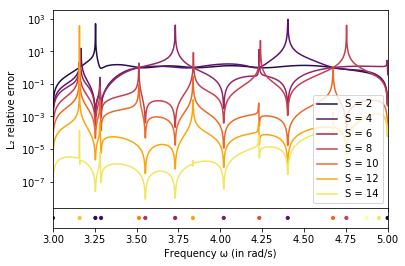

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [10, 1]})

omegas = np.linspace(a, b, 1000)
linspace = np.linspace(a-(b-a)/2000, b+(b-a)/2000, 1001)
RC.solve(linspace)
u_linspace = RC.get_solution(trace=VS.get_trace())

MRI = MinimalRationalInterpolation(VS)
n_iter = 16
surrogate_history = MRI.compute_surrogate(RC, omegas, greedy=True, n_iter=n_iter, return_history=True)

norms = []
n_supp = range(n_iter - 1)[2::2]
for i in n_supp:
    RI = surrogate_history[i-2]
    norms.append(helpers.plot_surrogate_error_norms(ax[0], RC, MRI, VS, u_linspace, linspace, RI,
        label='S = {}'.format(i), color=cm(i/(n_iter-1))))
nodes = MRI.u_ring.get_nodes()
ax[1].scatter(nodes, np.zeros_like(nodes), s=10, c=cm(np.arange(len(nodes))/(n_iter-1)), zorder=-n_iter)
ax[0].set_ylabel('L\u2082 relative error')
ax[1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[1].set_xlim(a, b)
ax[1].set_yticks([])
ax[0].legend()
plt.subplots_adjust(wspace=0, hspace=0)

In [29]:
#with open(root + '/report/plots/rectangular_cavity_errorprogression.pkl', 'wb') as f:
#    pickle.dump([norms, linspace, n_supp, n_iter, nodes, a, b], f) 

#### Demonstrate problem with suppressed eigenfrequencies

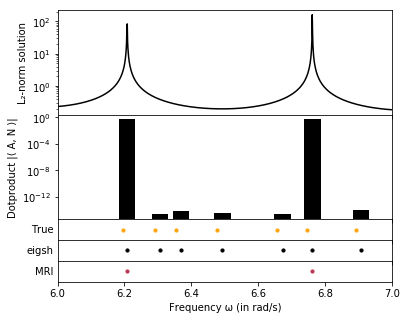

In [11]:
fig, ax = plt.subplots(5, 1, figsize=(6, 5), sharex=True, gridspec_kw={'height_ratios': [5, 5, 1, 1, 1]})

a = 6
b = 7
omegas = np.linspace(a, b, 1000)
RC.solve(omegas, solver='fenics')
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
norms = helpers.plot_solution_norms(ax[0], solution, VS, color='k')

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-2)

eigfreqs_numerical, eigvecs_numerical = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True, k=20)

ax[1].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
dotproducts = np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs_numerical])
ax[1].bar(eigfreqs_numerical, dotproducts, width=0.05, color='k')
ax[1].set_yscale('log')

ax[2].set_ylabel('True', rotation=0, ha='right', va='center')
eigfreqs_analytical = RC.get_analytical_eigenfrequencies(a, b)
ax[2].scatter(eigfreqs_analytical, np.zeros_like(eigfreqs_analytical), s=10, color=cm(0.8))
ax[2].set_yticks([])

ax[3].set_ylabel('eigsh', rotation=0, ha='right', va='center')
ax[3].scatter(eigfreqs_numerical, np.zeros_like(eigfreqs_numerical), s=10, color=cm(0.0))
ax[3].set_yticks([])

ax[4].set_ylabel('MRI', rotation=0, ha='right', va='center')
eigfreqs_rational = MRI.get_interpolatory_eigenfrequencies(only_real=True)
ax[4].scatter(eigfreqs_rational, np.zeros_like(eigfreqs_rational), s=10, color=cm(0.5))
ax[4].set_yticks([])

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)

plt.subplots_adjust(wspace=0, hspace=0)

In [ ]:
#with open(root + '/report/plots/rectangular_cavity_suppressed.pkl', 'wb') as f:
#    pickle.dump([omegas, norms, dotproducts, eigfreqs_analytical, eigfreqs_numerical, eigfreqs_rational], f)

### Analyze greedy minimal rational interpolation of trace

Relative range of singular values is 1.08e+13.
Relative range of singular values is 1.63e+13.
Relative range of singular values is 1.76e+13.
Relative range of singular values is 1.88e+13.
Relative range of singular values is 1.98e+13.
Relative range of singular values is 2.60e+13.
Relative range of singular values is 2.68e+13.


/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


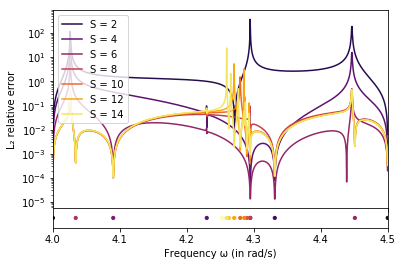

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [10, 1]})

VS = VectorSpaceL2(RC, inlet())

omegas = np.linspace(a, b, 1000)
linspace = np.linspace(a-(b-a)/2000, b+(b-a)/2000, 1001)
RC.solve(linspace)
u_linspace = RC.get_solution(trace=VS.get_trace())

MRI = MinimalRationalInterpolation(VS)
n_iter = 16
surrogate_history = MRI.compute_surrogate(RC, omegas, greedy=True, n_iter=n_iter, return_history=True)

# FOR PLOTTING ONLY
norms = []
n_supp = range(n_iter - 1)[2::2]
for i in n_supp:
    RI = surrogate_history[i-2]
    norms.append(helpers.plot_surrogate_error_norms(ax[0], RC, MRI, VS, u_linspace, linspace, RI,
        label='S = {}'.format(i), color=cm(i/(n_iter-1))))
nodes = MRI.u_ring.get_nodes()
ax[1].scatter(nodes, np.zeros_like(nodes), s=10, c=cm(np.arange(len(nodes))/(n_iter-1)), zorder=-n_iter)
ax[0].set_ylabel('L\u2082 relative error')
ax[1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[1].set_xlim(a, b)
ax[1].set_yticks([])
ax[0].legend()
plt.subplots_adjust(wspace=0, hspace=0)

In [21]:
#with open(root + '/report/plots/rectangular_cavity_trace_errorprogression.pkl', 'wb') as f:
#    pickle.dump([norms, linspace, n_supp, n_iter, nodes, a, b], f) 

#### Break symmetry with a cubby

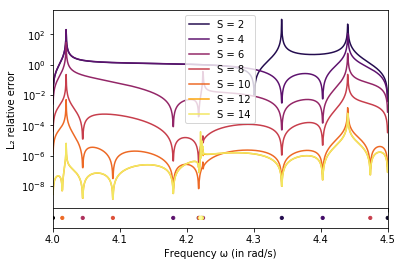

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [10, 1]})

Lx, Ly = 5.0, 1.0

domain = mshr.Rectangle(fen.Point(0.0, 0.0), fen.Point(Lx, Ly)) \
       + mshr.Rectangle(fen.Point(Lx*0.5, Ly), fen.Point(Lx*0.75, Ly*1.01))
mesh = mshr.generate_mesh(domain, 100)

class inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<Ly

m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
TDC = TwoDimensionalCavity(mesh=mesh, B_N=inlet, g_N=g_N)
TDC.setup()

VS = VectorSpaceL2(TDC, inlet())
a = 4
b = 4.5
omegas = np.linspace(a, b, 1000)
linspace = np.linspace(a-(b-a)/2000, b+(b-a)/2000, 1001)
TDC.solve(linspace)
u_linspace = TDC.get_solution(trace=VS.get_trace())

MRI = MinimalRationalInterpolation(VS)
n_iter = 16
surrogate_history = MRI.compute_surrogate(TDC, omegas, greedy=True, n_iter=n_iter, return_history=True)

norms = []
n_supp = range(n_iter - 1)[2::2]
for i in n_supp:
    RI = surrogate_history[i-2]
    norms.append(helpers.plot_surrogate_error_norms(ax[0], TDC, MRI, VS, u_linspace, linspace, RI,
        label='S = {}'.format(i), color=cm(i/(n_iter-1))))
nodes = MRI.u_ring.get_nodes()
ax[1].scatter(nodes, np.zeros_like(nodes), s=10, c=cm(np.arange(len(nodes))/(n_iter-1)), zorder=-n_iter)
ax[0].set_ylabel('L\u2082 relative error')
ax[1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[1].set_xlim(a, b)
ax[1].set_yticks([])
ax[0].legend()
plt.subplots_adjust(wspace=0, hspace=0)

In [23]:
#with open(root + '/report/plots/rectangular_cubby_trace_errorprogression.pkl', 'wb') as f:
#    pickle.dump([norms, linspace, n_supp, n_iter, nodes, a, b], f) 

### Compare eigensolver to rational interpolation

In [ ]:
Lx, Ly = 5.0, 1.0
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)

a = 3
b = 5
omegas = np.linspace(a, b, 100)

for N in np.logspace(3, 6, 4, dtype=int):
    RC = RectangularCavity(Lx=Lx, Ly=Ly, Nx=int(pow(N*Lx/(Lx+Ly), 0.5)), Ny=int(pow(N*Ly/(Lx+Ly), 0.5)), g_N=g_N)
    RC.setup()
    print(50*'#' + '\nRectangular cavity with {} DOFs\n'.format(RC.V.dim()) + 50*'-')
    VS = VectorSpaceL2(RC)
    eigfreqs_analytical = np.array(RC.get_analytical_eigenfrequencies(a, b))
    eigfreqs_numerical = np.array(RC.get_numerical_eigenfrequencies(a, b, k=6))
    print('eigsh')
    %timeit RC.get_numerical_eigenfrequencies(a, b)
    print('Mean absolute error {}'.format(np.mean(np.abs(eigfreqs_analytical - eigfreqs_numerical))))
    MRI = MinimalRationalInterpolation(VS)
    MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-2, solver='fenics') 
    eigfreqs_rational_unfiltered = MRI.get_interpolatory_eigenfrequencies()
    eigfreqs_rational = np.sort([np.real(e) for e in eigfreqs_rational_unfiltered[np.abs(np.imag(eigfreqs_rational_unfiltered)) < 1e-10] if a <= e and e <= b])
    print('MRI')
    %timeit MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-2, solver='fenics') ; MRI.get_interpolatory_eigenfrequencies()
    print('Mean absolute error {}'.format(np.mean(np.abs(eigfreqs_analytical - eigfreqs_rational))))

##################################################
Rectangular cavity with 713 DOFs
--------------------------------------------------
Increase parameter "k" to ensure all eigenvalues are found.
eigsh
25.9 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mean absolute error 0.019501121221686974
MRI
61.9 ms ± 3.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mean absolute error 0.019501804386025185
##################################################
Rectangular cavity with 7412 DOFs
--------------------------------------------------
Increase parameter "k" to ensure all eigenvalues are found.
eigsh
199 ms ± 9.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mean absolute error 0.0018259848240658922
MRI
410 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mean absolute error 0.0018267199206235911
##################################################
Rectangular cavity with 74722 DOFs
--------------------------------------------------
Increa